# Proyecto Telecom X - Etapa 2 - Machine Learning 
#    (Previsión de Evasión (Churn) de clientes.)


In [469]:
# Librarys used here

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import tabulate as tabulate
import folium
from pandas import json_normalize
from folium.plugins import HeatMap
import warnings
import dfply as dp
from pathlib import Path

warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

import json




import requests
import pickle

from pathlib import Path
from typing import Tuple, Callable, List

from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTENC

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, cross_validate, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, RocCurveDisplay
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.svm import SVC
from sklearn.inspection import permutation_importance
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import RobustScaler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report
from sklearn.metrics import RocCurveDisplay, roc_auc_score
import xgboost

from xgboost import XGBClassifier


### Descrption project

In this project, predictive models will be developed that can predict which customers are most likely to cancel their services.

The company wants to anticipate the churn problem explored in the previous stage. Therefore, in this notebook, a robust pipeline will be built for this initial modeling stage, in which the following tasks will be carried out:

Prepare the data for modeling (processing, coding, normalization).
Perform evaluation analysis and variable selection.
Train different classification models, evaluate their performance using different metrics, and interpret the results of each.
Finally, a report will be created with a strategic conclusion highlighting the main factors that influence churn.


#### Data dictionary 

- `customerID`: número de identificación único de cada cliente
- `Churn`: si el cliente dejó o no la empresa
- `gender`: género (masculino y femenino)
- `SeniorCitizen`: información sobre si un cliente tiene o no una edad igual o mayor a 65 años
- `Partner`: si el cliente tiene o no una pareja
- `Dependents`: si el cliente tiene o no dependientes
- `tenure`: meses de contrato del cliente
- `PhoneService`: suscripción al servicio telefónico
- `MultipleLines`: suscripción a más de una línea telefónica
- `InternetService`: suscripción a un proveedor de internet
- `OnlineSecurity`: suscripción adicional de seguridad en línea
- `OnlineBackup`: suscripción adicional de respaldo en línea
- `DeviceProtection`: suscripción adicional de protección del dispositivo
- `TechSupport`: suscripción adicional de soporte técnico, menor tiempo de espera
- `StreamingTV`: suscripción de televisión por cable
- `StreamingMovies`: suscripción de streaming de películas
- `Contract`: tipo de contrato
- `PaperlessBilling`: si el cliente prefiere recibir la factura en línea
- `PaymentMethod`: forma de pago
- `Charges.Monthly`: total de todos los servicios del cliente por mes
- `Charges.Total`: total gastado por el cliente

### Preprocessing data

de acuerdo al challenge anterior en donde se realizaron algunas cosas.....

In [299]:
# Load the dataset

#. → carpeta actual
#.. → carpeta padre (subir un nivel)

csv_path = Path("..") / "challenge-telecomX_Latam" / "TelecomX_Data_Cleaned.csv"
df1 = pd.read_csv(csv_path)


df1.head()

,customerID,Churn,customer.gender,customer.SeniorCitizen,customer.Partner,customer.Dependents,customer.tenure,phone.PhoneService,phone.MultipleLines,internet.InternetService,...,internet.OnlineBackup,internet.DeviceProtection,internet.TechSupport,internet.StreamingTV,internet.StreamingMovies,account.Contract,account.PaperlessBilling,account.PaymentMethod,account.Charges.Monthly,account.Charges.Total
0,0002-ORFBO,False,Female,False,True,True,9,True,False,DSL,...,1,0,1,1,0,One year,True,Mailed check,65.6,593.30
1,0003-MKNFE,False,Male,False,False,False,9,True,True,DSL,...,0,0,0,0,1,Month-to-month,False,Mailed check,59.9,542.40
2,0004-TLHLJ,True,Male,False,False,False,4,True,False,Fiber optic,...,0,1,0,0,0,Month-to-month,True,Electronic check,73.9,280.85
3,0011-IGKFF,True,Male,True,True,False,13,True,False,Fiber optic,...,1,1,0,1,1,Month-to-month,True,Electronic check,98.0,1237.85
4,0013-EXCHZ,True,Female,True,True,False,3,True,False,Fiber optic,...,0,0,1,1,0,Month-to-month,True,Mailed check,83.9,267.40


In [300]:
# trasform the DataFrame to have a more readable format

cat_cols = [ 'customer.gender','internet.InternetService','account.Contract','account.PaymentMethod',
            'internet.OnlineSecurity', 'internet.OnlineBackup', 'internet.DeviceProtection',
    'internet.TechSupport', 'internet.StreamingTV', 'internet.StreamingMovies']
for col in cat_cols:
    df1[col] = df1[col].astype('category')


# convert the 'customer.SeniorCitizen' column to boolean

cat_cols = ['customer.Partner', 'customer.Dependents', 'phone.PhoneService', 'phone.MultipleLines',
    'account.PaperlessBilling', 'Churn','customer.SeniorCitizen']

# remplace Yes/No with 1/0

df1 = df1.replace({'Yes': 1, 'No': 0})

for col in cat_cols:
    df1[col] = df2[col].astype('bool')
    

# convert the 'account.Charges.Total' column to float
df2['account.Charges.Total'] = df1['account.Charges.Total'].astype(float)

In [301]:
df2 = df1.drop(['customerID'], axis=1)
df2.dropna(inplace=True)

df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   Churn                      7032 non-null   object  
 1   customer.gender            7032 non-null   category
 2   customer.SeniorCitizen     7032 non-null   object  
 3   customer.Partner           7032 non-null   object  
 4   customer.Dependents        7032 non-null   object  
 5   customer.tenure            7032 non-null   int64   
 6   phone.PhoneService         7032 non-null   object  
 7   phone.MultipleLines        7032 non-null   object  
 8   internet.InternetService   7032 non-null   category
 9   internet.OnlineSecurity    7032 non-null   category
 10  internet.OnlineBackup      7032 non-null   category
 11  internet.DeviceProtection  7032 non-null   category
 12  internet.TechSupport       7032 non-null   category
 13  internet.StreamingTV       7032 non-nu

In Challenge Part 1 of the project, we successfully conducted a comprehensive Exploratory Data Analysis (EDA) focused on understanding customer churn behavior within TelecomX LATAM. This included thorough data cleaning, variable transformation, and the identification of key trends and correlations. We analyzed how different factors such as contract type, tenure, payment method, and monthly charges influence churn rates. Additionally, we examined variable distributions, addressed missing values, detected multicollinearity, and gained actionable business insights.

## Encoding for categorical fields

In [302]:
df2.columns

# Categorical columns to be encoded

categoricas = [
    'customer.gender',
    'customer.SeniorCitizen',
    'customer.Partner',
    'customer.Dependents',
    'phone.PhoneService',
    'phone.MultipleLines',
    'internet.InternetService',
    'account.Contract',
    'account.PaymentMethod'
]


In [303]:
# Encoding for categorical fields

one_hot = make_column_transformer(
                    (OneHotEncoder(drop='first'), categoricas),
                    remainder='passthrough',
                    sparse_threshold=0
)



label_encoder = LabelEncoder()

In [304]:
# Split the DataFrame into features and target variable

X = df2.drop('Churn', axis=1)
y = df2['Churn']



In [305]:
X= one_hot.fit_transform(X)

y = label_encoder.fit_transform(y)


In [306]:
# Get the feature names after one-hot encoding

columnas = one_hot.get_feature_names_out() # output feature names

columnas_encoded = [col.split("__")[1] for col in columnas]



In [307]:
# Transform the encoded features into a DataFrame
dfencoded = pd.DataFrame(X, columns=columnas_encoded)

#  Transform the target variable into a DataFrame
df_ytarget = pd.DataFrame(y, columns=['Churn'])


dffinal = pd.concat([dfencoded, df_ytarget], axis=1)

dffinal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 24 columns):
 #   Column                                         Non-Null Count  Dtype 
---  ------                                         --------------  ----- 
 0   customer.gender_Male                           7032 non-null   object
 1   customer.SeniorCitizen_True                    7032 non-null   object
 2   customer.Partner_True                          7032 non-null   object
 3   customer.Dependents_True                       7032 non-null   object
 4   phone.PhoneService_True                        7032 non-null   object
 5   phone.MultipleLines_True                       7032 non-null   object
 6   internet.InternetService_DSL                   7032 non-null   object
 7   internet.InternetService_Fiber optic           7032 non-null   object
 8   account.Contract_One year                      7032 non-null   object
 9   account.Contract_Two year                      7032 non-null   

In [309]:
for col in dffinal.columns:
    print(f"Columna: {col}")
    print(dffinal[col].value_counts())  # count each unique value (True/False or 0/1)
    print("-" * 30)

Columna: customer.gender_Male
customer.gender_Male
1.0    3549
0.0    3483
Name: count, dtype: int64
------------------------------
Columna: customer.SeniorCitizen_True
customer.SeniorCitizen_True
0.0    5890
1.0    1142
Name: count, dtype: int64
------------------------------
Columna: customer.Partner_True
customer.Partner_True
0.0    3639
1.0    3393
Name: count, dtype: int64
------------------------------
Columna: customer.Dependents_True
customer.Dependents_True
0.0    4933
1.0    2099
Name: count, dtype: int64
------------------------------
Columna: phone.PhoneService_True
phone.PhoneService_True
1.0    6352
0.0     680
Name: count, dtype: int64
------------------------------
Columna: phone.MultipleLines_True
phone.MultipleLines_True
1.0    3647
0.0    3385
Name: count, dtype: int64
------------------------------
Columna: internet.InternetService_DSL
internet.InternetService_DSL
0.0    4616
1.0    2416
Name: count, dtype: int64
------------------------------
Columna: internet.Inte

# Different distribution of tenure

In [352]:
def bin_width(df, col):
    q75, q25 = np.percentile(df[col], [75 ,25])
    iqr = q75 - q25
    n = len(df[col])
    width = 2 * iqr / np.cbrt(n)  # Freedman-Diaconi

In [351]:
scaler_total = StandardScaler()

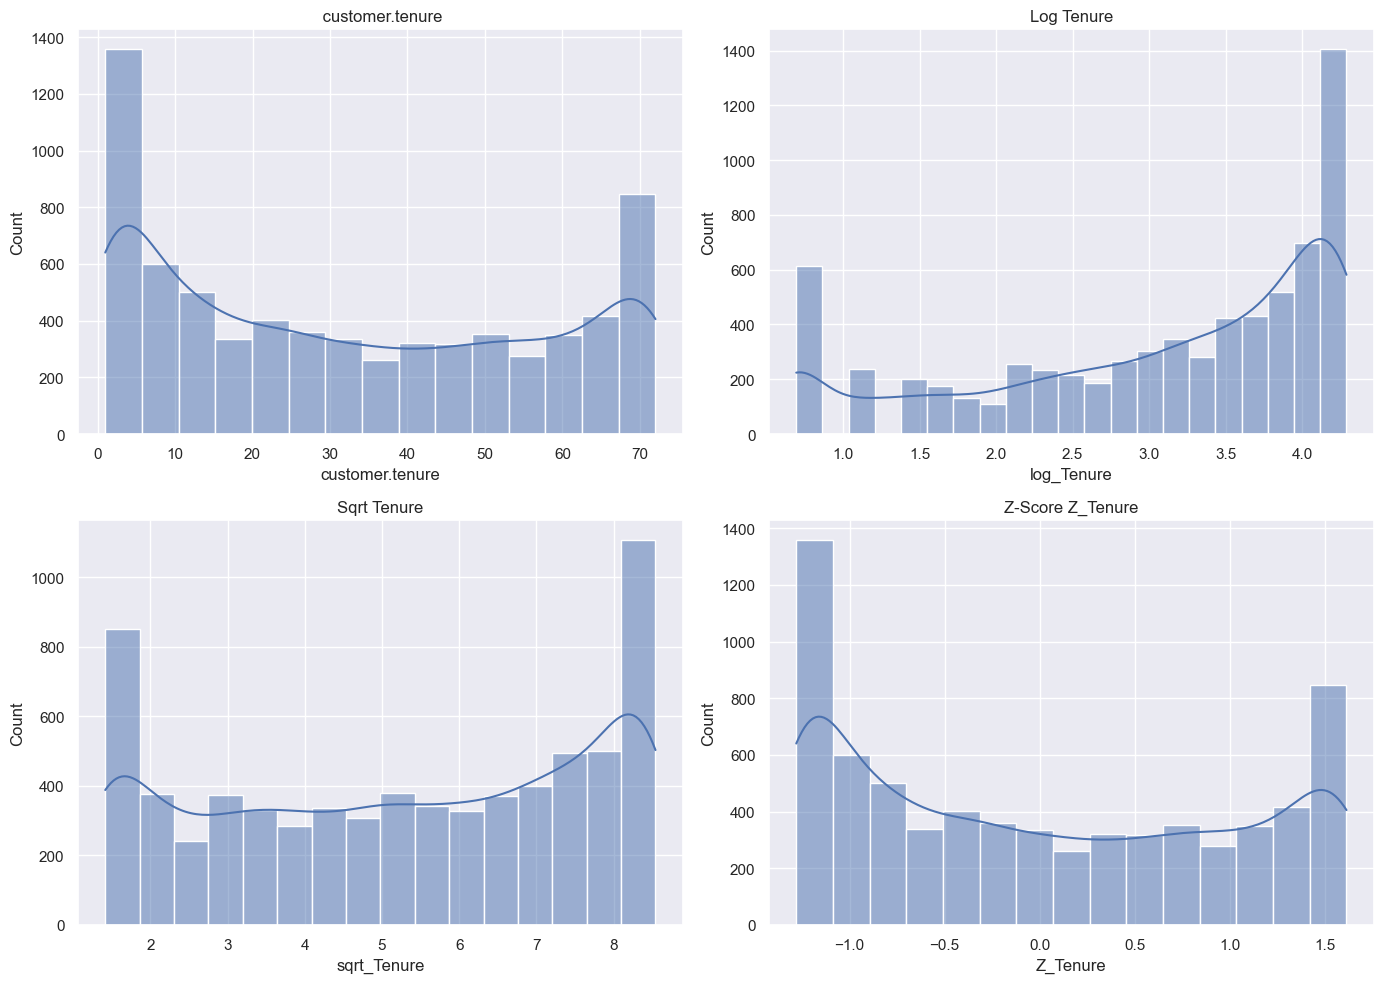

In [350]:
# Suponiendo que ya tienes df y churn_colors
fig, axes = plt.subplots(2, 2, figsize=(14, 10))  # 2 filas x 2 columnas
axes = axes.flatten()  # Aplanar para iterar más fácil

# 1️⃣ Histograma original Tenure
BIN_WIDTH = bin_width(df2, 'customer.tenure')
sns.histplot(df2['customer.tenure'], binwidth=BIN_WIDTH, kde=True, ax=axes[0])
axes[0].set_title(' customer.tenure')

# 2️⃣ Log transform
df2['log_Tenure'] = np.log(df2['customer.tenure'] + 1)
BIN_WIDTH = bin_width(df2, 'log_Tenure')
sns.histplot(df2['log_Tenure'], binwidth=BIN_WIDTH, kde=True, ax=axes[1])
axes[1].set_title('Log Tenure')

# 3️⃣ Square root transform
df2['sqrt_Tenure'] = np.sqrt(df2['customer.tenure'] + 1)
BIN_WIDTH = bin_width(df2, 'sqrt_Tenure')
sns.histplot(df2['sqrt_Tenure'], binwidth=BIN_WIDTH, kde=True, ax=axes[2])
axes[2].set_title('Sqrt Tenure')

# 4️⃣ Z-score
df2['Z_Tenure'] = scaler_total.fit_transform(df2[['customer.tenure']])
BIN_WIDTH = bin_width(df2, 'Z_Tenure')
sns.histplot(df2['Z_Tenure'], binwidth=BIN_WIDTH, kde=True, ax=axes[3])
axes[3].set_title('Z-Score Z_Tenure')


# Ajustar layout
plt.tight_layout()
plt.show()

In [313]:
scaler_monthly = StandardScaler()

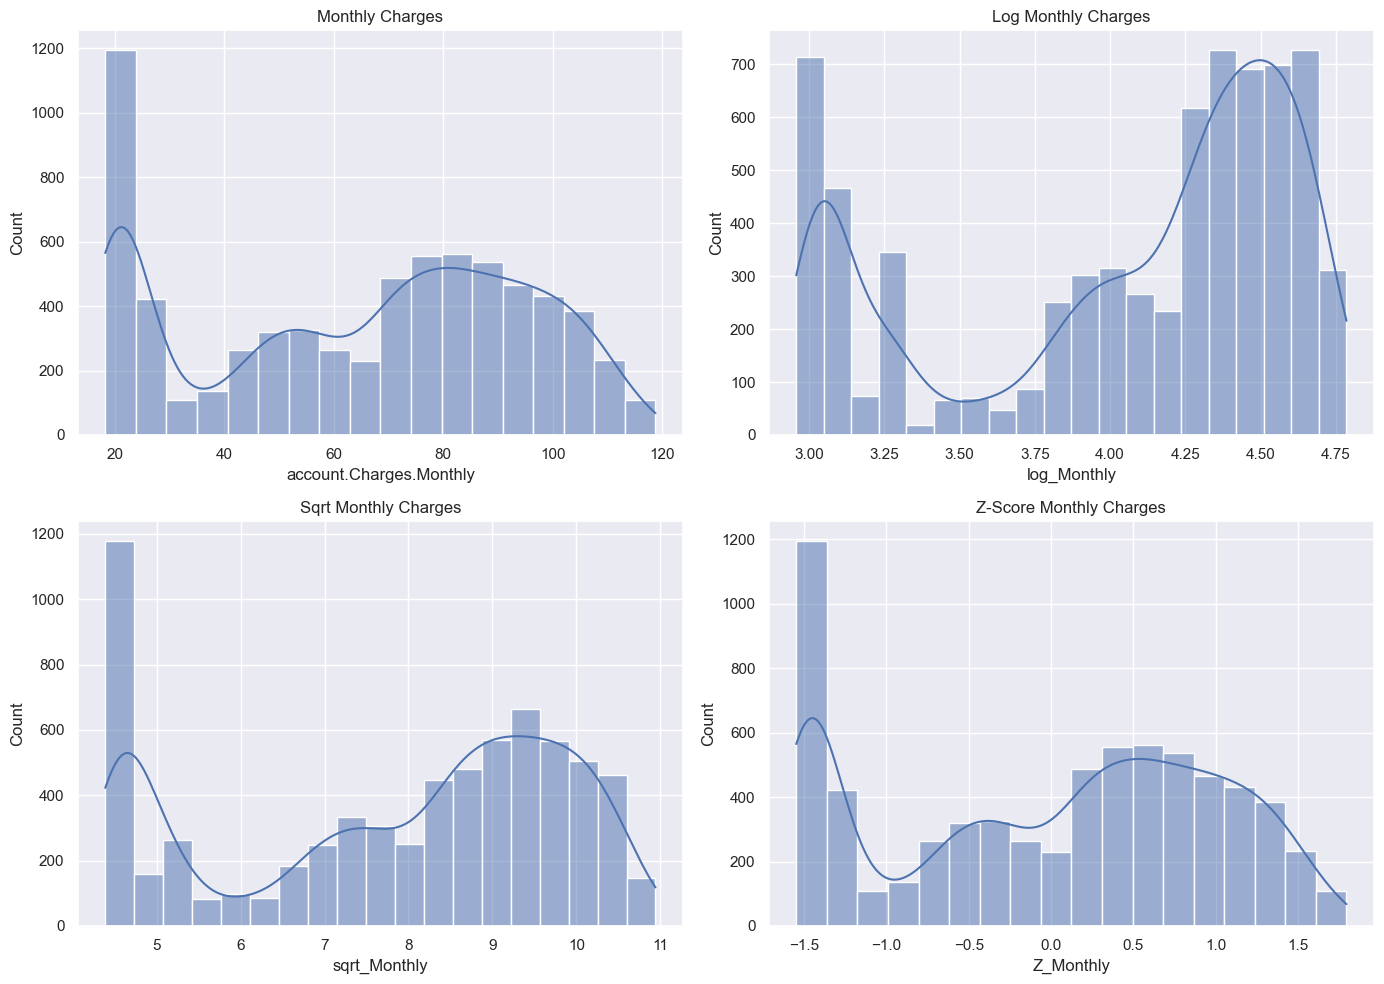

In [349]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

# 1️⃣ histogram
BIN_WIDTH = bin_width(dffinal, 'account.Charges.Monthly')
sns.histplot(dffinal['account.Charges.Monthly'], binwidth=BIN_WIDTH, kde=True, ax=axes[0])
axes[0].set_title('Monthly Charges')

# 2️⃣ Log transform
dffinal['log_Monthly'] = np.log(dffinal['account.Charges.Monthly'] + 1)
BIN_WIDTH = bin_width(dffinal, 'log_Monthly')
sns.histplot(dffinal['log_Monthly'], binwidth=BIN_WIDTH, kde=True, ax=axes[1])
axes[1].set_title('Log Monthly Charges')

# 3️⃣ Square root transform
dffinal['sqrt_Monthly'] = np.sqrt(dffinal['account.Charges.Monthly'] + 1)
BIN_WIDTH = bin_width(dffinal, 'sqrt_Monthly')
sns.histplot(dffinal['sqrt_Monthly'], binwidth=BIN_WIDTH, kde=True, ax=axes[2])
axes[2].set_title('Sqrt Monthly Charges')

# 4️⃣ Z-score
dffinal['Z_Monthly'] = scaler_monthly.fit_transform(dffinal[['account.Charges.Monthly']])
BIN_WIDTH = bin_width(dffinal, 'Z_Monthly')
sns.histplot(dffinal['Z_Monthly'], binwidth=BIN_WIDTH, kde=True, ax=axes[3])
axes[3].set_title('Z-Score Monthly Charges')

# layout
plt.tight_layout()
plt.show()

In [ ]:

scaler_total = StandardScaler()

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

# 1️⃣ Histograma original
BIN_WIDTH = bin_width(dffinal, 'account.Charges.Total')
sns.histplot(dffinal['account.Charges.Total'], binwidth=BIN_WIDTH, kde=True, ax=axes[0])
axes[0].set_title('Total Charges')

# 2️⃣ Log transform
dffinal['log_Total'] = np.log(dffinal['account.Charges.Total'] + 1)
BIN_WIDTH = bin_width(dffinal, 'log_Total')
sns.histplot(dffinal['log_Total'], binwidth=BIN_WIDTH, kde=True, ax=axes[1])
axes[1].set_title('Log Total Charges')

# 3️⃣ Square root transform
dffinal['sqrt_Total'] = np.sqrt(dffinal['account.Charges.Total'] + 1)
BIN_WIDTH = bin_width(dffinal, 'sqrt_Total')
sns.histplot(dffinal['sqrt_Total'], binwidth=BIN_WIDTH, kde=True, ax=axes[2])
axes[2].set_title('Sqrt Total Charges')

# 4️⃣ Z-score
dffinal['Z_Total'] = scaler_total.fit_transform(dffinal[['account.Charges.Total']])
BIN_WIDTH = bin_width(dffinal, 'Z_Total')
sns.histplot(dffinal['Z_Total'], binwidth=BIN_WIDTH, kde=True, ax=axes[3])
axes[3].set_title('Z-Score Total Charges')

# Ajustar layout
plt.tight_layout()
plt.show()

**Distribution of ChargesTotal**

It can be observed that none of the applied transformations (log, square root, Z-score) successfully correct the positive skew of the ChargesTotal variable. This is expected, as it is a cumulative variable, where most customers have low values, and only a small group reaches high amounts.

Outlier records (high-value customers who churned) were deliberately included, as analyzing them helps identify patterns and shared characteristics with lower-value customers, highlighting critical areas for improvement to reduce Churn.

**Distribution of Tenure and ChargesMonthly**

Both variables show a bimodal distribution, which remains consistent across all transformations. This indicates the presence of two distinct groups of customers based on tenure and monthly charges.

Such insights are useful for customer segmentation, tailoring retention strategies, and adapting pricing or benefits according to the profile of each group.

**Decision on Transformations and Scaling**

Since transformations do not correct skewness or affect the bimodal patterns, quantitative variables will be kept in their original state for predictive modeling.

However, if a model proves sensitive to variable scales ( linear regression or distance-based models like KNN), RobustScaler may be applied to preserve distribution shape while reducing the influence of outliers.

In [371]:
cols_to_drop = [
    'log_Tenure', 'sqrt_Tenure', 'Z_Tenure',
    'log_Monthly', 'sqrt_Monthly', 'Z_Monthly',
    'log_Total', 'sqrt_Total', 'Z_Total'
]

# Eliminar columnas si existen
dffinal.drop(columns=[col for col in cols_to_drop if col in dffinal.columns], inplace=True)

In [348]:
# Detectar columnas que contienen 'No internet service' o 'Yes'/'No'
cols_to_replace = []
for col in dffinal.select_dtypes(include='object').columns:
    if dffinal[col].isin(['No internet service', 'Yes', 'No']).any():
        cols_to_replace.append(col)

# Reemplazar valores por 0 y 1
for col in cols_to_replace:
    dffinal[col] = dffinal[col].replace({
        'No internet service': 0,
        'No': 0,
        'Yes': 1
    }).astype(int)
    

# 1️⃣ Convertir columnas binarias de object a int
binary_cols = [
    'customer.gender_Male', 'customer.SeniorCitizen_True', 'customer.Partner_True',
    'customer.Dependents_True', 'phone.PhoneService_True', 'phone.MultipleLines_True',
    'account.PaperlessBilling'
]

for col in binary_cols:
    dffinal[col] = dffinal[col].replace({0:0, 1:1, '0':0, '1':1, True:1, False:0}).astype(int)

# 2️⃣ Convertir charges a float
dffinal['account.Charges.Monthly'] = dffinal['account.Charges.Monthly'].astype(float)
dffinal['account.Charges.Total'] = dffinal['account.Charges.Total'].astype(float)

# 3️⃣ Seleccionar todas las columnas numéricas
numeric_cols = dffinal.select_dtypes(include=['int64', 'int32', 'float64']).columns

dffinal[numeric_cols].info()
dffinal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   customer.gender_Male         7032 non-null   int32  
 1   customer.SeniorCitizen_True  7032 non-null   int32  
 2   customer.Partner_True        7032 non-null   int32  
 3   customer.Dependents_True     7032 non-null   int32  
 4   phone.PhoneService_True      7032 non-null   int32  
 5   phone.MultipleLines_True     7032 non-null   int32  
 6   internet.OnlineSecurity      7032 non-null   int32  
 7   internet.OnlineBackup        7032 non-null   int32  
 8   internet.DeviceProtection    7032 non-null   int32  
 9   internet.TechSupport         7032 non-null   int32  
 10  internet.StreamingTV         7032 non-null   int32  
 11  internet.StreamingMovies     7032 non-null   int32  
 12  account.PaperlessBilling     7032 non-null   int32  
 13  account.Charges.Mo

In [408]:

# Calcular la matriz de correlación
corr = dffinal[numeric_cols].corr()
numeric_cols


Index(['customer.gender_Male', 'customer.SeniorCitizen_True',
       'customer.Partner_True', 'customer.Dependents_True',
       'phone.PhoneService_True', 'phone.MultipleLines_True',
       'internet.OnlineSecurity', 'internet.OnlineBackup',
       'internet.DeviceProtection', 'internet.TechSupport',
       'internet.StreamingTV', 'internet.StreamingMovies',
       'account.PaperlessBilling', 'account.Charges.Monthly',
       'account.Charges.Total', 'Churn'],
      dtype='object')

In [346]:
corr.columns

Index(['customer.gender_Male', 'customer.SeniorCitizen_True',
       'customer.Partner_True', 'customer.Dependents_True',
       'phone.PhoneService_True', 'phone.MultipleLines_True',
       'internet.OnlineSecurity', 'internet.OnlineBackup',
       'internet.DeviceProtection', 'internet.TechSupport',
       'internet.StreamingTV', 'internet.StreamingMovies',
       'account.PaperlessBilling', 'account.Charges.Monthly',
       'account.Charges.Total', 'Churn'],
      dtype='object')

In [339]:
mascara = np.zeros_like(corr, dtype=bool)
mascara[np.triu_indices_from(mascara)] = True

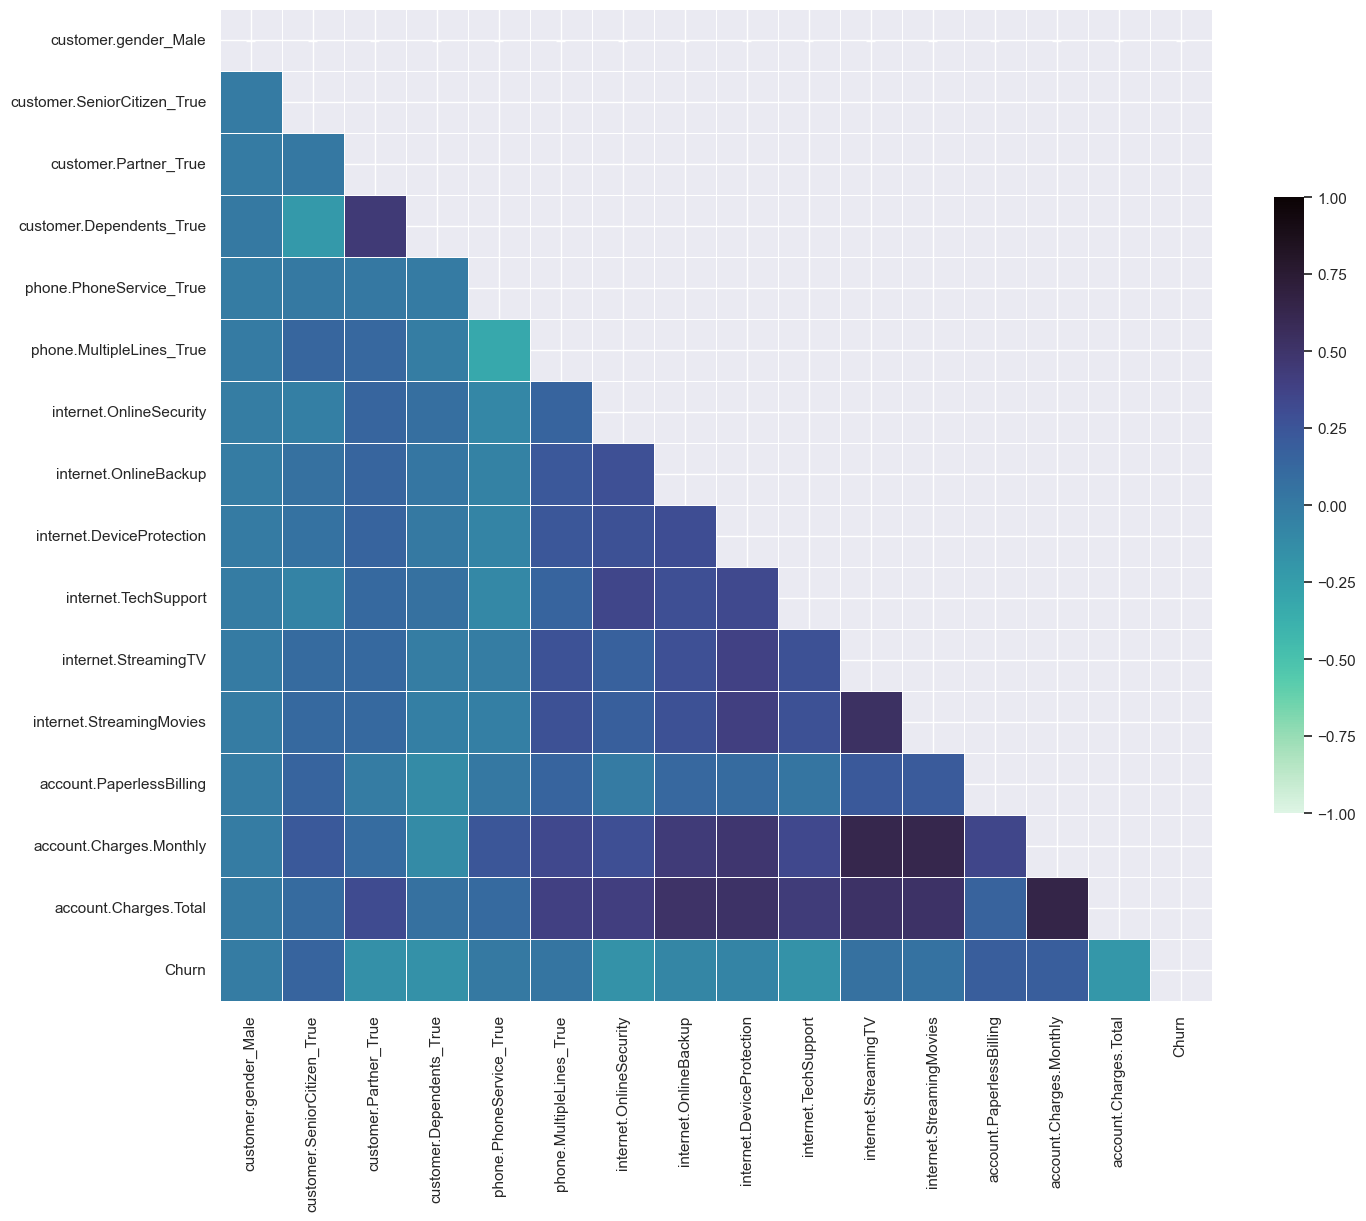

In [406]:
mascara = np.triu(np.ones_like(corr, dtype=bool))

# Graficar heatmap
plt.figure(figsize=(16,16))
sns.heatmap(
    np.round(corr, 3),   # redondear a 3 decimales
    mask=mascara,        # <-- aquí usas la máscara
    vmax=1, vmin=-1, 
    center=0,
    square=True, 
    linewidths=.5, 
    annot=True,          # anotar los números
    fmt=".2f",           # formato de los números
    cbar_kws={"shrink": .5}, 
    cmap='mako_r'
)
plt.show()

In [341]:
cols = corr.loc['Churn'].abs()[corr.loc['Churn'].abs() > 0.07].index
corr_selected = corr[cols].loc[cols]  # Subset del DataFrame completo
corr_selected

,customer.SeniorCitizen_True,customer.Partner_True,customer.Dependents_True,internet.OnlineSecurity,internet.OnlineBackup,internet.TechSupport,account.PaperlessBilling,account.Charges.Monthly,account.Charges.Total,Churn
customer.SeniorCitizen_True,1.000000,0.016957,-0.210550,-0.038576,0.066663,-0.060577,0.156258,0.219874,0.102411,0.150541
customer.Partner_True,0.016957,1.000000,0.452269,0.143346,0.141849,0.120206,-0.013957,0.097825,0.319072,-0.149982
customer.Dependents_True,-0.210550,0.452269,1.000000,0.080786,0.023639,0.063053,-0.110131,-0.112343,0.064653,-0.163128
internet.OnlineSecurity,-0.038576,0.143346,0.080786,1.000000,0.283285,0.354458,-0.004051,0.296447,0.412619,-0.171270
internet.OnlineBackup,0.066663,0.141849,0.023639,0.283285,1.000000,0.293705,0.127056,0.441529,0.510100,-0.082307
internet.TechSupport,-0.060577,0.120206,0.063053,0.354458,0.293705,1.000000,0.037536,0.338301,0.432868,-0.164716
account.PaperlessBilling,0.156258,-0.013957,-0.110131,-0.004051,0.127056,0.037536,1.000000,0.351930,0.157830,0.191454
account.Charges.Monthly,0.219874,0.097825,-0.112343,0.296447,0.441529,0.338301,0.351930,1.000000,0.651065,0.192858
account.Charges.Total,0.102411,0.319072,0.064653,0.412619,0.510100,0.432868,0.157830,0.651065,1.000000,-0.199484
Churn,0.150541,-0.149982,-0.163128,-0.171270,-0.082307,-0.164716,0.191454,0.192858,-0.199484,1.000000


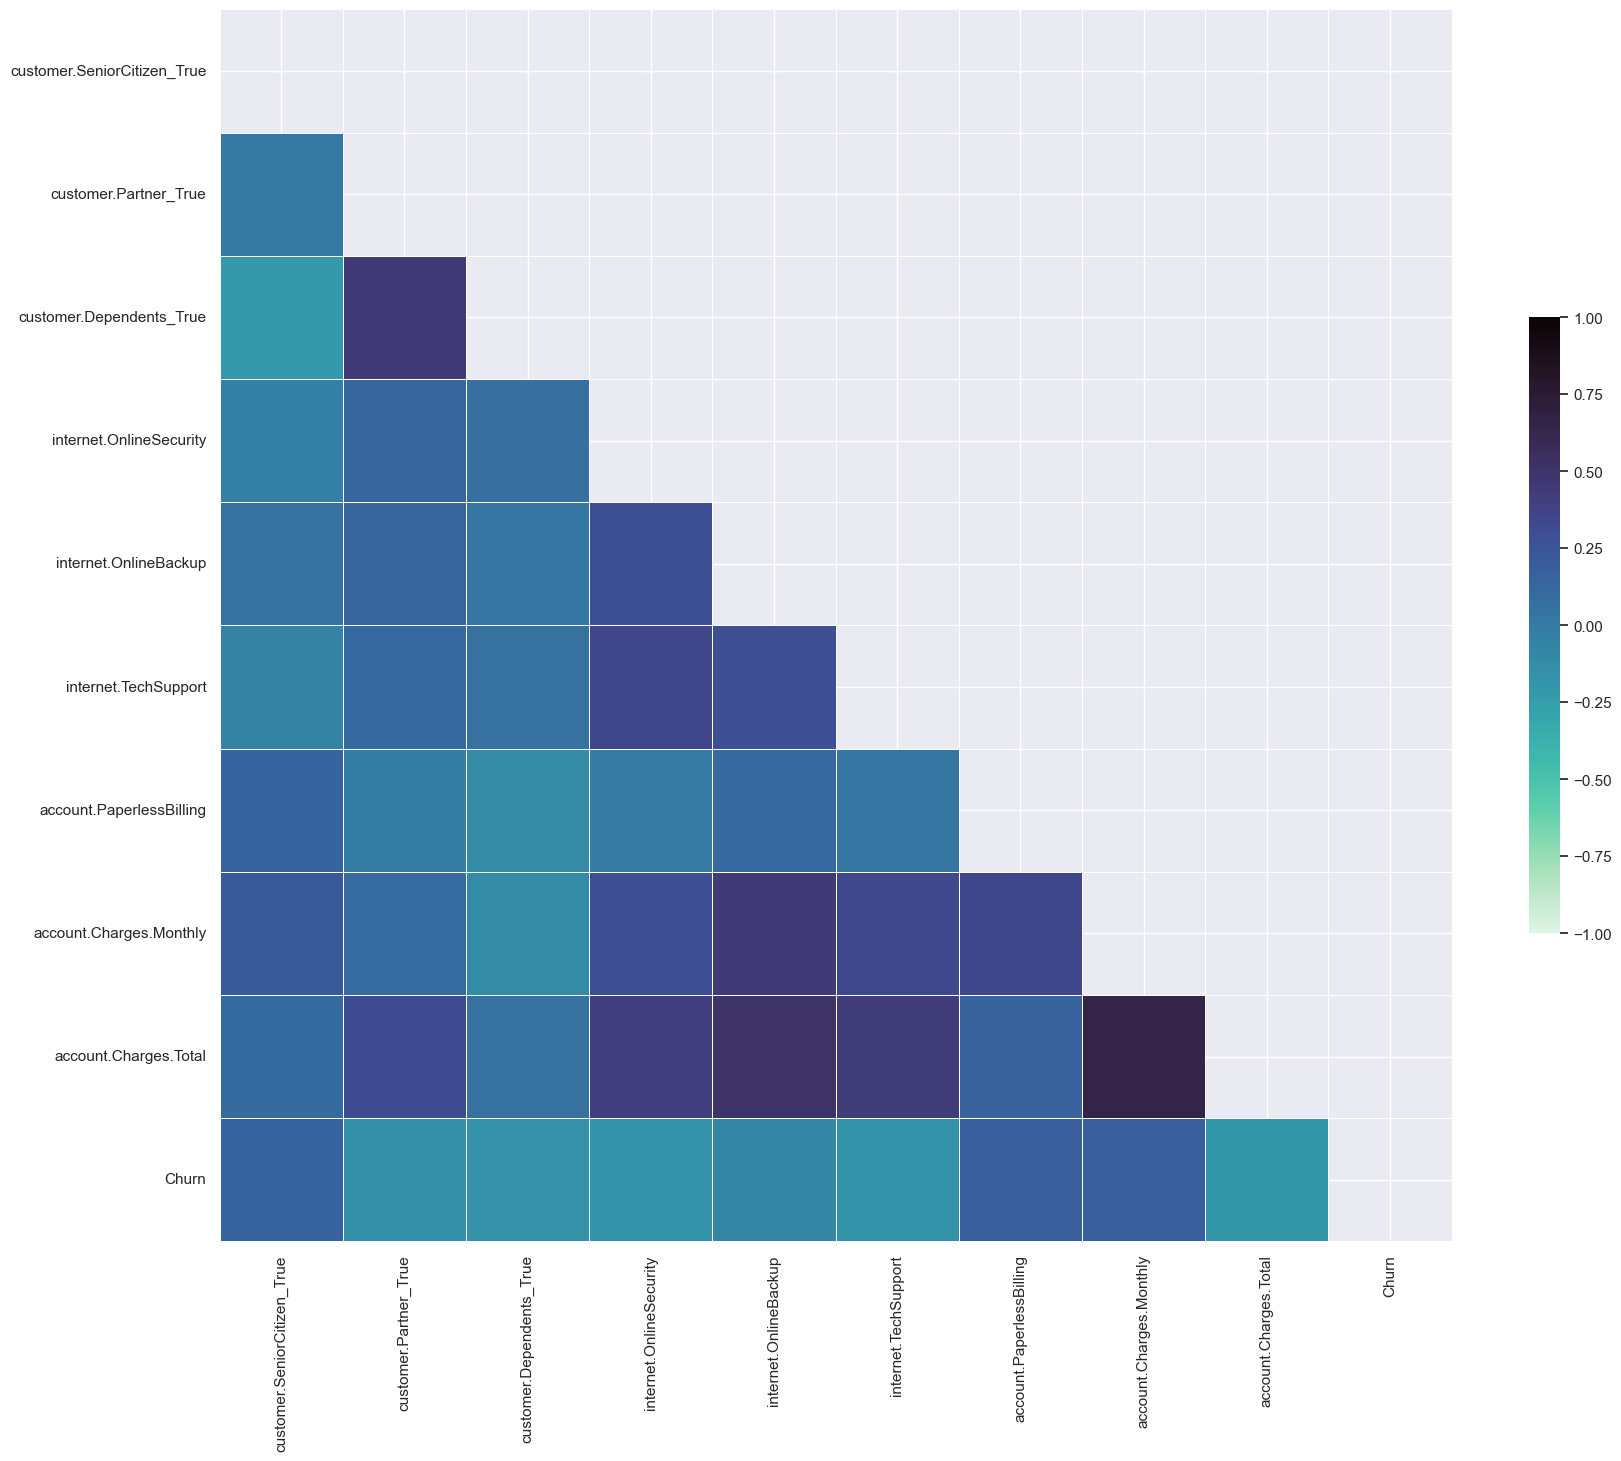

In [405]:
# Generar máscara para el subset seleccionado
mascara = np.zeros_like(corr_selected, dtype=bool)
mascara[np.triu_indices_from(mascara)] = True

# Graficar heatmap
fig, ax = plt.subplots(figsize=(20,16))
sns.heatmap(
    np.round(corr_selected, 3), 
    mask=mascara,
    vmax=1, vmin=-1, center=0,
    square=True, linewidths=.5, annot=True, 
    cbar_kws={"shrink": .5}, cmap='mako_r'
)
plt.show()


In [398]:
vif_robust_scaler = RobustScaler()
df_vif = dffinal

In [399]:
x_num = ['customer.tenure','account.Charges.Monthly', 'account.Charges.Total']

X_vif_num = df_vif[x_num]

X_vif_num = vif_robust_scaler.fit_transform(X_vif_num)

df_vif[['customer.tenure_scaled','ChargesMonthly_scaled', 'ChargesTotal_scaled']] = X_vif_num

df_vif = df_vif.drop(['customer.tenure','account.Charges.Monthly', 'account.Charges.Total'], axis=1)

In [400]:

X_vif = df_vif.drop('Churn', axis=1)
X_vif = X_vif.fillna(0)
features = X_vif.columns
features


Index(['customer.gender_Male', 'customer.SeniorCitizen_True',
       'customer.Partner_True', 'customer.Dependents_True',
       'phone.PhoneService_True', 'phone.MultipleLines_True',
       'internet.InternetService_DSL', 'internet.InternetService_Fiber optic',
       'account.Contract_One year', 'account.Contract_Two year',
       'account.PaymentMethod_Credit card (automatic)',
       'account.PaymentMethod_Electronic check',
       'account.PaymentMethod_Mailed check', 'internet.OnlineSecurity',
       'internet.OnlineBackup', 'internet.DeviceProtection',
       'internet.TechSupport', 'internet.StreamingTV',
       'internet.StreamingMovies', 'account.PaperlessBilling',
       'ChargesMonthly_scaled', 'ChargesTotal_scaled',
       'customer.tenure_scaled'],
      dtype='object')

In [401]:

df_vif_1 = pd.DataFrame()
df_vif_1['Feature'] = features
df_vif_1['VIF'] = [vif(X_vif[features], i) for i in range(len(features))]

In [402]:

X_vif = df_vif.drop('Churn', axis=1)

In [403]:

df_vif_1.sort_values('VIF', ascending=False)

,Feature,VIF
21,ChargesTotal_scaled,12.459021
7,internet.InternetService_Fiber optic,10.271208
4,phone.PhoneService_True,8.175615
22,customer.tenure_scaled,7.727743
20,ChargesMonthly_scaled,6.755060
6,internet.InternetService_DSL,4.292790
9,account.Contract_Two year,3.486627
11,account.PaymentMethod_Electronic check,2.976650
18,internet.StreamingMovies,2.974072
19,account.PaperlessBilling,2.967113


In [ ]:
# Análisis Dirigido
## Verification of Churn Proportion

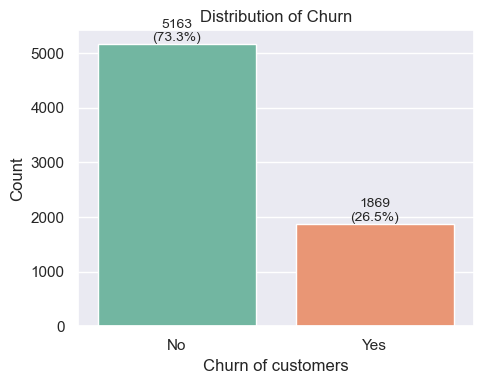

In [308]:
plt.figure(figsize=(5, 4))
ax = sns.countplot(x='Churn', data=dffinal, palette='Set2')
plt.title("Distribution of Churn")
plt.xlabel("Churn of customers")
plt.ylabel("Count")
plt.xticks([0, 1], ['No', 'Yes'])

# Calcular proporciones
total = len(df1)
for p in ax.patches:
    count = int(p.get_height())
    percent = 100 * count / total
    ax.annotate(f'{count}\n({percent:.1f}%)', 
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

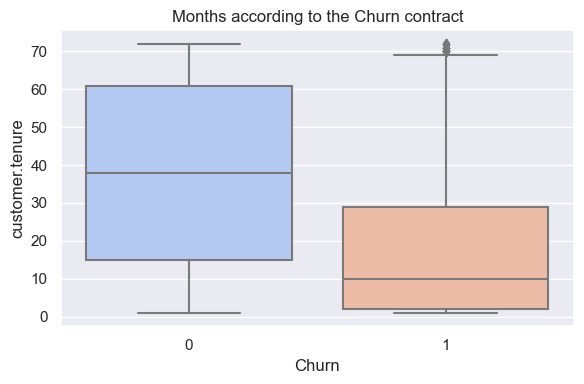

In [411]:
plt.figure(figsize=(6,4))
sns.boxplot(x='Churn', y='customer.tenure', data=df2, palette='coolwarm')
plt.title("Months according to the Churn contract")
plt.xticks([0, 1], ['0', '1'])
plt.tight_layout()
plt.show()

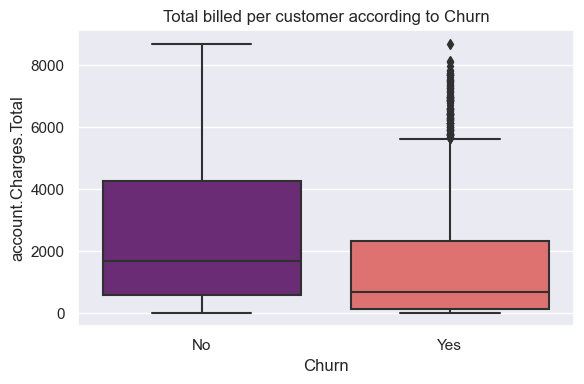

In [412]:
plt.figure(figsize=(6,4))
sns.boxplot(x='Churn', y='account.Charges.Total', data=df2, palette='magma')
plt.title("Total billed per customer according to Churn")
plt.xticks([0, 1], ['No', 'Yes'])
plt.tight_layout()
plt.show()

# Data Models

### split data

#### Separete target and features

In [ ]:

features = dffinal.drop(columns=['Churn'])
target = dffinal['Churn']


X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, stratify=y, random_state=42)



Index(['customer.gender_Male', 'customer.SeniorCitizen_True',
       'customer.Partner_True', 'customer.Dependents_True',
       'phone.PhoneService_True', 'phone.MultipleLines_True',
       'internet.InternetService_DSL', 'internet.InternetService_Fiber optic',
       'account.Contract_One year', 'account.Contract_Two year',
       'account.PaymentMethod_Credit card (automatic)',
       'account.PaymentMethod_Electronic check',
       'account.PaymentMethod_Mailed check', 'customer.tenure',
       'internet.OnlineSecurity', 'internet.OnlineBackup',
       'internet.DeviceProtection', 'internet.TechSupport',
       'internet.StreamingTV', 'internet.StreamingMovies',
       'account.PaperlessBilling', 'account.Charges.Monthly',
       'account.Charges.Total', 'Churn', 'ChargesMonthly_scaled',
       'ChargesTotal_scaled', 'customer.tenure_scaled'],
      dtype='object')

In [423]:
# Normalizar data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [424]:
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train_scaled, y_train)



y_train_bal.value_counts()

Churn
1    3614
0    3614
Name: count, dtype: int64

In [ ]:

# Instanciar y entrenar
lr = LogisticRegression(random_state=42, max_iter=10000, class_weight='balanced')
lr.fit(X_train_bal, y_train_bal)

# Predicciones
y_pred_lr = lr.predict(X_test_scaled)
y_prob_lr = lr.predict_proba(X_test_scaled)[:, 1]

# Evaluación
print("Regresión Logística")
print("Exactitud:", accuracy_score(y_test, y_pred_lr))
print("ROC AUC:", roc_auc_score(y_test, y_prob_lr))
print("Matriz de Confusión:\n", confusion_matrix(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))

Regresión Logística
Exactitud: 0.7492890995260664
ROC AUC: 0.8454951673726595
Matriz de Confusión:
 [[1126  423]
 [ 106  455]]
              precision    recall  f1-score   support

           0       0.91      0.73      0.81      1549
           1       0.52      0.81      0.63       561

    accuracy                           0.75      2110
   macro avg       0.72      0.77      0.72      2110
weighted avg       0.81      0.75      0.76      2110



## Decision Tree Classifier

In [437]:
skf = StratifiedKFold(n_splits=6, shuffle=True, random_state=42)

In [440]:
treedesicion_model = DecisionTreeClassifier(
    max_depth=10, 
    random_state=42
)

scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

cv_results = cross_validate(
    treedesicion_model, X_train_bal, y_train_bal, cv=skf, scoring=scoring, return_train_score=False
)

In [442]:
treedesicion_model.fit(X_train_bal, y_train_bal)

DecisionTreeClassifier(max_depth=10, random_state=42)

In [450]:
treedesicion_pred = treedesicion_model.predict(X_test)

print(classification_report(y_test, treedesicion_pred))

              precision    recall  f1-score   support

           0       0.84      0.76      0.80      1549
           1       0.47      0.58      0.52       561

    accuracy                           0.71      2110
   macro avg       0.65      0.67      0.66      2110
weighted avg       0.74      0.71      0.72      2110



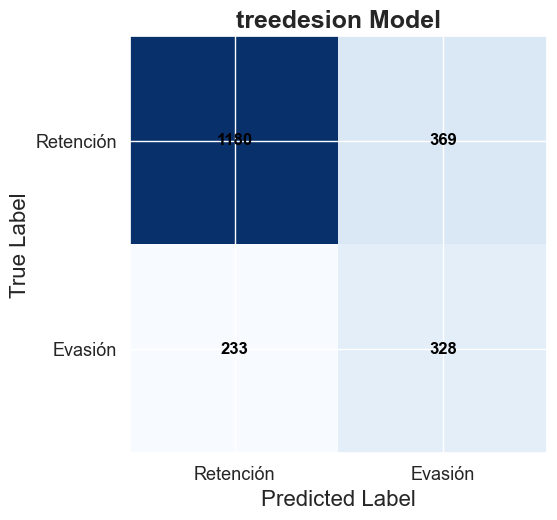

In [456]:
# Calcular matriz de confusión
confmat = confusion_matrix(y_true=y_test, y_pred=treedesicion_pred)

# Crear display con etiquetas
confmat_plot = ConfusionMatrixDisplay(confmat, display_labels=['Retención', 'Evasión'])

# Graficar
fig, ax = plt.subplots(figsize=(10,6))
confmat_plot.plot(ax=ax, cmap="Blues", colorbar=False,
                  text_kw={'color': 'black', 'fontweight': 'bold'})

plt.title("treedesion Model", fontsize=18, fontweight='bold')
plt.xlabel("Predicted Label", fontsize=16)
plt.ylabel("True Label", fontsize=16)
plt.tick_params(axis='both', labelsize=13)

plt.tight_layout(pad=3.0)
plt.show()

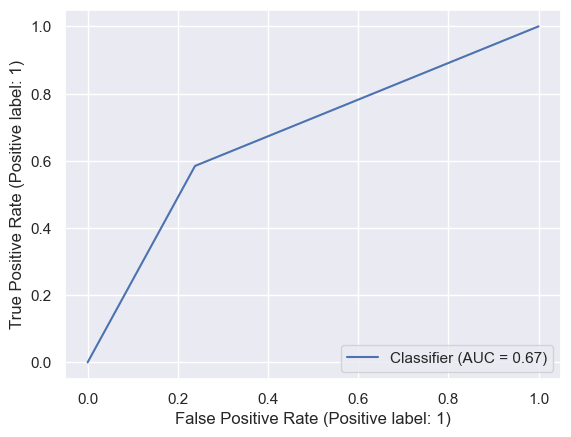

In [457]:
RocCurveDisplay.from_predictions(y_test, treedesicion_pred);

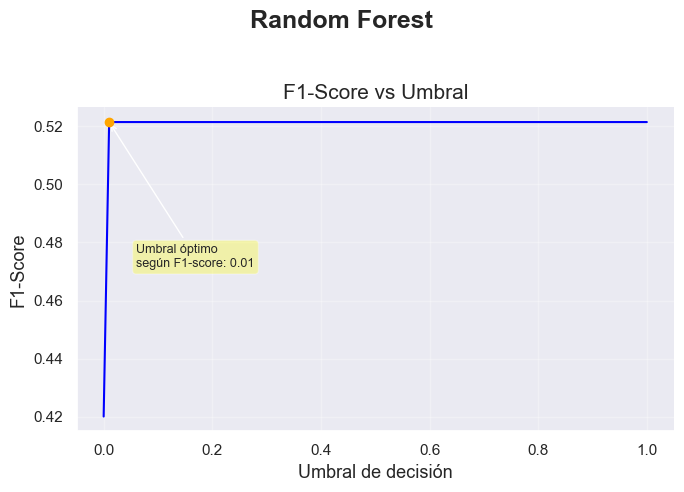

In [ ]:
# Definir rango de umbrales
umbrales = np.linspace(0.0, 1.0, 100)
scores = []

# Probabilidades del modelo
randomf_proba = treedesicion_model.predict_proba(X_test)[:, 1]

# Calcular F1 para cada umbral
for t in umbrales:
    y_pred = (randomf_proba >= t).astype(int)
    scores.append(f1_score(y_test, y_pred))

# Graficar
fig, ax = plt.subplots(figsize=(7,5))
plt.suptitle("baseline", fontsize=18, fontweight='bold')

plt.plot(umbrales, scores, label='F1-Score', color="blue")
plt.title('F1-Score vs Umbral', fontsize=15)
plt.xlabel("Umbral de decisión", fontsize=13)
plt.ylabel("F1-Score", fontsize=13)
plt.grid(True, alpha=0.3)

# Encontrar el mejor umbral
idx_max = np.argmax(scores)
mejor_umbral = umbrales[idx_max]
mejor_valor = scores[idx_max]

# Resaltar mejor punto
plt.scatter(mejor_umbral, mejor_valor, color="orange", zorder=5)
plt.annotate(
    f'Umbral óptimo\nsegún F1-score: {mejor_umbral:.2f}',
    xy=(mejor_umbral, mejor_valor),
    xytext=(mejor_umbral + 0.05, mejor_valor - 0.05),
    arrowprops=dict(facecolor='black', arrowstyle='->'),
    bbox=dict(boxstyle='round,pad=0.3', fc='yellow', alpha=0.3),
    fontsize=9
)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

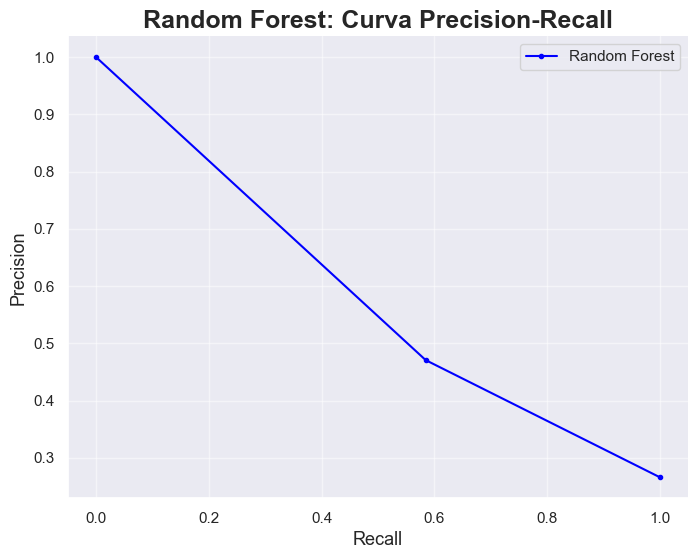

In [ ]:
from sklearn.metrics import precision_recall_curve


# Probabilidades de la clase positiva
y_pred = treedesicion_model.predict_proba(X_test)[:, 1]

# Calcular precisión, recall y umbrales
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

# Graficar la curva
fig, ax = plt.subplots(figsize=(8, 6))
plt.plot(recall, precision, marker='.', color="blue", label="Random Forest")
plt.title("baseline: Curva Precision-Recall", fontsize=18, fontweight='bold')
plt.xlabel('Recall', fontsize=13)
plt.ylabel('Precision', fontsize=13)

plt.legend()
plt.grid(True, alpha=0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()


# Random Forest Classifier

In [462]:
rf = RandomForestClassifier(max_depth=10, random_state=42)

rf_cv_results = cross_validate(rf, X_train, y_train, cv=skf, scoring='recall')

In [463]:

rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, random_state=42)

In [464]:
Randomf = rf.predict(X_test)

print(classification_report(y_test, Randomf))

              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1549
           1       0.64      0.49      0.56       561

    accuracy                           0.79      2110
   macro avg       0.74      0.70      0.71      2110
weighted avg       0.78      0.79      0.78      2110



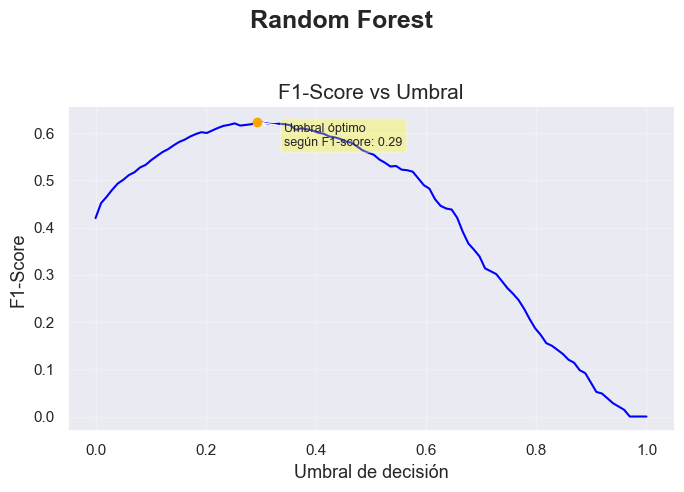

In [477]:

# Definir rango de umbrales
umbrales = np.linspace(0.0, 1.0, 100)
scores = []

# Probabilidades del modelo
randomf_proba = rf.predict_proba(X_test)[:, 1]

# Calcular F1 para cada umbral
for t in umbrales:
    y_pred = (randomf_proba >= t).astype(int)
    scores.append(f1_score(y_test, y_pred))

# Graficar
fig, ax = plt.subplots(figsize=(7,5))
plt.suptitle("Random Forest", fontsize=18, fontweight='bold')

plt.plot(umbrales, scores, label='F1-Score', color="blue")
plt.title('F1-Score vs Umbral', fontsize=15)
plt.xlabel("Umbral de decisión", fontsize=13)
plt.ylabel("F1-Score", fontsize=13)
plt.grid(True, alpha=0.3)

# Encontrar el mejor umbral
idx_max = np.argmax(scores)
mejor_umbral = umbrales[idx_max]
mejor_valor = scores[idx_max]

# Resaltar mejor punto
plt.scatter(mejor_umbral, mejor_valor, color="orange", zorder=5)
plt.annotate(
    f'Umbral óptimo\nsegún F1-score: {mejor_umbral:.2f}',
    xy=(mejor_umbral, mejor_valor),
    xytext=(mejor_umbral + 0.05, mejor_valor - 0.05),
    arrowprops=dict(facecolor='black', arrowstyle='->'),
    bbox=dict(boxstyle='round,pad=0.3', fc='yellow', alpha=0.3),
    fontsize=9
)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


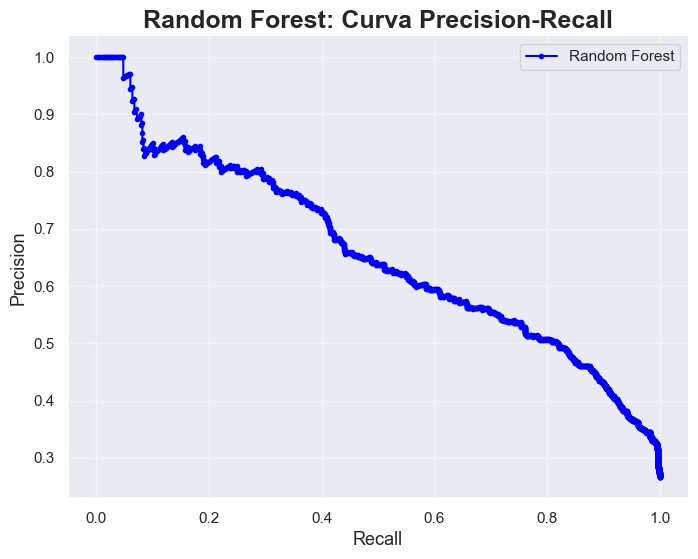

In [478]:
from sklearn.metrics import precision_recall_curve


# Probabilidades de la clase positiva
y_pred = rf.predict_proba(X_test)[:, 1]

# Calcular precisión, recall y umbrales
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

# Graficar la curva
fig, ax = plt.subplots(figsize=(8, 6))
plt.plot(recall, precision, marker='.', color="blue", label="Random Forest")
plt.title("Random Forest: Curva Precision-Recall", fontsize=18, fontweight='bold')
plt.xlabel('Recall', fontsize=13)
plt.ylabel('Precision', fontsize=13)

plt.legend()
plt.grid(True, alpha=0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()


# Informe: Cancelación de clientes (Churn) – Desarrollo de modelos y hallazgos

## 1) Objetivo
Predecir la probabilidad de cancelación (Churn) e identificar los **drivers** que más aportan al riesgo, para diseñar **estrategias de retención** enfocadas.

---

## 2) Datos y preparación

**Alcance del dataset**
- Variable objetivo: **Churn** (binaria).
- Grupos de variables: **Cuenta** (cargos mensuales y totales), **Contrato** (tipo y plazo), **Servicios** (Internet/Seguridad/Backup/Soporte/Streaming), **Teléfono**, y **Demografía** (Pareja, Dependientes, SeniorCitizen).

**Limpieza**
- Estandarización de categorías (“Yes/No/No internet service” → binario/one-hot).
- Conversión de numéricas (MonthlyCharges, TotalCharges, Tenure).
- Imputación de nulos:
  - Numéricas: mediana.
  - Categóricas: categoría “Desconocido” o moda.
- Detección de **altas correlaciones** para evitar multicolinealidad.
- Balance de clases:
  - **class_weight='balanced'** o **SMOTE** (en entrenamiento).

**Partición**
- **Train/Test** (80/20) con **estratificación por Churn**.
- Escalado:
  - **Regresión Logística**: StandardScaler.
  - **Árboles / RF**: no requiere.

---

## 3) Ingeniería de variables

- **Contratos**: one-hot (Mensual, 1 año, 2 años).
- **Servicios de valor agregado**: binarios (OnlineSecurity, OnlineBackup, TechSupport, DeviceProtection, StreamingTV, StreamingMovies).
- **Uso/valor**: MonthlyCharges, TotalCharges, Tenure.
- **Interacciones**:
  - Mensual × MonthlyCharges  
  - Servicios ausentes × MonthlyCharges

---

## 4) Modelos y validación

### 4.1 Regresión Logística
- Pipeline: imputación → escalado → L2.
- Validación cruzada estratificada (k=5).
- Selección de umbral: curva **F1 vs threshold**.
- **Interpretación (odds ratios)**:
  - Contrato mensual ↑ churn.
  - Sin servicios extra ↑ churn.
  - Tenure alto ↓ churn.

### 4.2 Árbol de Decisión
- Hiperparámetros: max_depth, min_samples_split, min_samples_leaf.
- Fácil interpretabilidad → reglas claras.
- Drivers: **Contrato**, **MonthlyCharges**, **Servicios extra**.

### 4.3 Random Forest
- Ensamble de árboles con bootstrap.
- Hiperparámetros: n_estimators, max_depth, class_weight.
- Mejor desempeño en F1 y ROC-AUC.
- Importancias: Contrato, MonthlyCharges, Tenure, Servicios.

**Métricas**
- Validación cruzada: Recall, Precision, **F1**, ROC-AUC, PR-AUC.
- Test: matriz de confusión, curva ROC, curva Precision-Recall.

---

## 5) Ajuste de umbral

- Se optimizó el **umbral** según **F1**.  
- **Trade-off**:
  - Umbral bajo → Recall ↑, Precision ↓.
  - Umbral alto → Precision ↑, Recall ↓.

---

## 6) Interpretabilidad y drivers

**Logística**
- Contrato mensual ↑ riesgo.
- Sin OnlineSecurity/Backup/TechSupport ↑ riesgo.
- MonthlyCharges altos ↑ riesgo.
- Tenure alto ↓ riesgo.

**Random Forest**
1. Tipo de contrato  
2. MonthlyCharges  
3. OnlineSecurity / TechSupport / DeviceProtection / OnlineBackup  
4. Tenure  
5. Streaming (retentivo)

---

## 7) Recomendaciones de negocio

1. **Migración de contrato mensual → anual/bianual**  
   - Descuentos, meses gratis, upgrades.  
   - Ofrecerlo antes de facturación.

2. **Paquetes de valor (seguridad/backup/soporte)**  
   - Bundles con precio preferente.  
   - Mensaje: protección + continuidad.

3. **Precios altos percibidos**  
   - Ajuste de plan o beneficios extra.

4. **Segmentos críticos**  
   - Mensual + sin servicios + cargos altos.  
   - Contacto proactivo.

5. **Monitoreo continuo**  
   - Re-entrenar mensualmente.  
   - Revisar drift y recalibrar umbral.

---

## 8) Buenas prácticas técnicas

- **Heatmap**: la máscara debe tener la misma forma que el DataFrame.
- **VIF**: solo numéricas y sin NaN/Inf.
- **predict_proba**: siempre desde el modelo, no desde arrays.
- **ROC vs F1**:  
  - ROC-AUC para discriminación global.  
  - PR-AUC para clases desbalanceadas.  
  - F1/Recall/Precision para elegir umbral.

---

## 9) Conclusión ejecutiva

- Drivers más fuertes: **Contrato Mensual**, **servicios de valor ausentes**, **cargos altos**.  
- **Random Forest**: mejor desempeño global.  
- **Regresión Logística**: mayor interpretabilidad.  
- El modelo permite activar **campañas preventivas** eficientes:  
  - Priorizar clientes con **alto score de churn**.  
  - Ofertas alineadas a **drivers específicos** (plan, precio, servicios).
